### Load data

In [1]:
import pickle
with open('splitData.pickle', 'rb') as f:
    texts_train = pickle.load(f)
    texts_val = pickle.load(f)
    texts_test = pickle.load(f)
    labels_train = pickle.load(f)
    labels_val = pickle.load(f)
    labels_test = pickle.load(f)

all_texts  = texts_train  + texts_val  + texts_test
all_labels = labels_train + labels_val + labels_test
# check the ratio of each dataset
total = len(texts_train) + len(texts_val) + len(texts_test)
len(texts_train)/total, len(texts_val)/total, len(texts_test)/total

(0.5997757847533632, 0.20011210762331838, 0.20011210762331838)

# Q2-Clustering

### Step 0: Vectorise text

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

# fitted_vectorizer = vectorizer.fit(texts)
# texts_vector = fitted_vectorizer.transform(texts)
texts_vector = vectorizer.fit_transform(all_texts)
texts_vector.shape

(1784, 22406)

## Conducting Kmeans

In [3]:
import numpy as np
def kmeans(k, matrix, max_iter=300):
    num_data, dim_feature = matrix.shape

    # Step1: pick k random centroids
    #### centroids = np.random.random([k,22406]) -- to be deleted
    # pick centroids from data randomly to make sure at least one point is allocated to one point
    centroids = matrix[np.random.randint(0,num_data,k)]


    # new centroids to be calculated
    new_centroids = np.zeros((k,dim_feature))

    # labels(=index of centroids) assigned to data
    labels = np.zeros(num_data)

    # iterate until convergence or max_iteration
    for itr in range(max_iter):
        
        # iterate through all data
        for i in range(num_data):
            # matrix is a sparse vector, so make it dense array
            ith_vec = np.squeeze(np.asarray(matrix[i].todense()))

            #Step2: Assign each vector to its closest centroid
            dists = np.sum(np.square(centroids - ith_vec), axis=1)
            labels[i] = np.argmin(dists)

        #Step3:Recalculate the centroids
        for j in range(k):
            new_centroids[j] = matrix[labels==j].mean(axis=0)

        # If step 2 and 3 converges, exit for-loop         
        if np.all(new_centroids == centroids):
            print("converged")
            break;
        centroids = new_centroids

    return labels, new_centroids


clustered_labels, centroids = kmeans(5,texts_vector)
from collections import Counter
clustered_labels = [str(int(l)) for l in clustered_labels]
Counter(clustered_labels)

converged


Counter({'2': 691, '1': 612, '0': 468, '4': 10, '3': 3})

### For answering questions

In [4]:
# question a)
for i in range(5):
    print(f"------top 5 tokens in centroid {i}-----")
    indices = np.argsort(centroids[i])[-5:] # indices of most prominent tokens
    for key,val in vectorizer.vocabulary_.items():
        if val in indices:
            print(f'{key}',end=",")
    print("\n")

# tokenizerを工夫したほうがよいかも

------top 5 tokens in centroid 0-----
the,you,yeah,oh,ooh,

------top 5 tokens in centroid 1-----
to,the,you,it,and,

------top 5 tokens in centroid 2-----
to,the,you,it,me,

------top 5 tokens in centroid 3-----
magic,july,siegfried,roy,stadium,

------top 5 tokens in centroid 4-----
happy,mm,glad,jugg,serious,



In [5]:
# cm=confusion_matrix(clustered_labels, all_labels)
# ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['not clinical trial','clinical trial']).plot()

# confusion matrixの完成形がわからん

<AxesSubplot:xlabel='k-means labels', ylabel='target labels'>

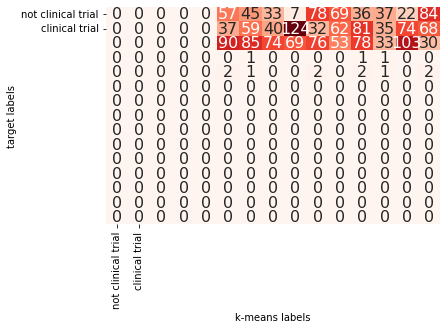

In [6]:
# question c) construct a confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sn

def plotConfusionMatrix(labels_val, labels_predicted):
  cm = confusion_matrix(labels_val, labels_predicted)
  colour_map = sn.color_palette("Reds", as_cmap=True)
  labels = ['not clinical trial', 'clinical trial']
  plot = sn.heatmap(cm, 
                    annot=True, # Put the numbers in
                    annot_kws={"size": 16}, # Make the numbers bigger
                    fmt='g', # Stop scientific notation
                    cmap = colour_map, # Choose the colour palette
                    cbar = False, # Don't include the colour bar
                    xticklabels=labels, # Put in the X and Y labels
                    yticklabels=labels)
  plot.set(xlabel='k-means labels', ylabel='target labels')
  return plot

plotConfusionMatrix(clustered_labels, all_labels)

In [7]:
from sklearn.cluster import KMeans
from collections import Counter
kmeans = KMeans(n_clusters=5, random_state=10).fit_predict(texts_vector)
Counter(kmeans)

Counter({2: 818, 1: 321, 3: 64, 4: 502, 0: 79})

# Q3-Comparing Classifiers

In [8]:

# Show classifier performance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def showPerformance(labels_true, labels_predicted):
    print(f'accuracy ={accuracy_score(labels_true, labels_predicted):.3f}')
    print(f'precision={precision_score(labels_true, labels_predicted, average="macro"):.3f}')
    print(f'recall   ={recall_score(labels_true, labels_predicted, average="macro"):.3f}') 
    print(f'f1       ={f1_score(labels_true, labels_predicted, average="macro"):.3f}')
    return ;


### Dummy Classifier with strategy="most_frequent"

In [9]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(texts_train,labels_train)
labels_predicted = dummy_clf.predict(texts_val)

print(dummy_clf.score(texts_val, labels_val))
showPerformance(labels_val, labels_predicted)

0.08403361344537816
accuracy =0.084
precision=0.008
recall   =0.100
f1       =0.016


/home/denjo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Dummy Classifier with strategy="most_frequent"

In [10]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(texts_train,labels_train)
labels_predicted = dummy_clf.predict(texts_val)

# print(dummy_clf.score(texts_val, labels_val))
showPerformance(labels_val, labels_predicted)

accuracy =0.106
precision=0.123
recall   =0.106
f1       =0.109


### LogisticRegression with one-hot vectorization

In [31]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
vectorizer = CountVectorizer()

vect_texts_train = vectorizer.fit_transform(texts_train)
vect_texts_train[vect_texts_train != 0] = 1 # convert non-zero counting into 1

vect_texts_val = vectorizer.transform(texts_val)
vect_texts_val[vect_texts_val != 0] = 1

# Logistic Regression
clf = LogisticRegression(random_state=42,max_iter=1000).fit(vect_texts_train, labels_train)
labels_predicted = clf.predict(vect_texts_val)


showPerformance(labels_val, labels_predicted)

accuracy =0.557
precision=0.540
recall   =0.555
f1       =0.544


### LogisticRegression with TF-IDF vectorization

In [12]:
vectorizer = TfidfVectorizer()
vect_texts_train = vectorizer.fit_transform(texts_train)
vect_texts_val = vectorizer.transform(texts_val)

# Logistic Regression
clf = LogisticRegression(random_state=42).fit(vect_texts_train, labels_train)
labels_predicted = clf.predict(vect_texts_val)


showPerformance(labels_val, labels_predicted)


accuracy =0.437
precision=0.511
recall   =0.433
f1       =0.406


### SVC Classifier with One-hot vectorization

In [13]:
# making one-hot vectors
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vect_texts_train = vectorizer.fit_transform(texts_train)
vect_texts_train[vect_texts_train != 0] = 1 # convert non-zero counting into 1

vect_texts_val = vectorizer.transform(texts_val)
vect_texts_val[vect_texts_val != 0] = 1

from sklearn.svm import SVC
clf = SVC(random_state=42).fit(vect_texts_train, labels_train)
labels_predicted = clf.predict(vect_texts_val)


showPerformance(labels_val, labels_predicted)

accuracy =0.546
precision=0.538
recall   =0.537
f1       =0.497


/home/denjo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Q4-Parameter Tuning

#### choose C value

In [26]:
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid
param_C = {'C':np.logspace(-3,5,9,base=10.0)}

max_f1 = 0
best_param = {}
for params in tqdm(ParameterGrid(param_C)):
  # vectorize training set and validation set
  vectorizer = TfidfVectorizer()
  vect_texts_train = vectorizer.fit_transform(texts_train)
  vect_texts_val = vectorizer.transform(texts_val)

  # logistic regression
  clf = LogisticRegression(random_state=42,C=params['C'],max_iter=1000).fit(vect_texts_train, labels_train)
  labels_predicted = clf.predict(vect_texts_val)

  cur_f1 = f1_score(labels_val, labels_predicted,average="macro")
  if(cur_f1 > max_f1):
    max_f1 = cur_f1
    best_param = params

print(f'{best_param=}')
print(f'{max_f1:.3f}')



100%|██████████| 9/9 [01:54<00:00, 12.74s/it]

best_param={'C': 100.0}
0.504


#### choose vectorizer

In [32]:
param_vec = {'max_features':[None, 5, 50, 500, 5000, 50000], 'sublinear_tf':[True,False]}

max_f1 = 0
best_param = {}
for params in tqdm(ParameterGrid(param_vec)):
  # vectorize training set and validation set
  vectorizer = TfidfVectorizer(max_features=params["max_features"], sublinear_tf=params["sublinear_tf"])
  vect_texts_train = vectorizer.fit_transform(texts_train)
  vect_texts_val = vectorizer.transform(texts_val)

  # logistic regression
  clf = LogisticRegression(random_state=42,C=100,max_iter=1000).fit(vect_texts_train, labels_train)
  labels_predicted = clf.predict(vect_texts_val)

  cur_f1 = f1_score(labels_val, labels_predicted,average="macro")
  if(cur_f1 > max_f1):
    max_f1 = cur_f1
    best_param = params

print(f'{best_param=}')
print(f'{max_f1:.3f}')


  8%|▊         | 1/12 [00:12<02:17, 12.53s/it]